# Clusters de sapatos - Mateus Magnus Paape

## Introdução

Um dos maiores problemas do e-commerce é agrupar produtos baseado na visão do usuário e não em características como cor, preço e fabricante. Uma necessidade é corrigir preços.

Uma das formas de atacar este problema é usando as features conhecidas (preço, cores, fabricante, categorias da estrutura mercadológica, etc) par agerar um vetor que represente o produto, e encontrar clusters que os agrupem usando alguma métrica de distância vetorial.

Vamos atacar este problema com um dataset de sapatos.

## Dados

Temos um conjunto de dados de registros de vendas de sapatos, cada sapato está identificado por um *id* único, e as linhas o apresentam em diversas ofertas de lojas onlne com cores, a categorização do site em que é ofertado, condição da oferta (novo ou usado), marca e preço cobrado.

In [289]:
import pandas as pd
df = pd.read_json("shoes.json", orient="records", lines=True)

In [290]:
df.head(10)

,id,brand,categories,colors,condition,isSale,price
0,AVpfEf_hLJeJML431ueH,Naturalizer,"[Clothing, Heels, All Women's Shoes, Shoes, Sa...","[Silver, Cream]",USED,False,55.990
1,AVpi74XfLJeJML43qZAc,MUK LUKS,"[Clothing, All Women's Shoes, Women's Casual S...",[Grey],NEW,True,41.125
2,AVpi74XfLJeJML43qZAc,MUK LUKS,"[Clothing, All Women's Shoes, Women's Casual S...",[Grey],NEW,False,35.250
3,AVpjXyCc1cnluZ0-V-Gj,MUK LUKS,"[Clothing, All Women's Shoes, Shoes, Women's S...",[Black],NEW,False,24.750
4,AVphGKLPilAPnD_x1Nrm,MUK LUKS,"[Clothing, All Women's Shoes, Shoes, Women's S...",[Grey],NEW,True,31.695
5,AVpg91ziilAPnD_xziOo,Soft Ones,"[Clothing, All Womens Shoes, All Women's Shoes...",[Brown],NEW,True,10.950
6,AVpjGKXyLJeJML43r8BH,MUK LUKS,"[Clothing, Women's Casual Shoes, All Women's S...","[Navy, Burgundy, Brown, Purple, Black, Natural...",USED,False,18.395
7,AVpjGKXyLJeJML43r8BH,MUK LUKS,"[Clothing, Women's Casual Shoes, All Women's S...","[Navy, Burgundy, Brown, Purple, Black, Natural...",USED,False,18.395
8,AVpfLXyhilAPnD_xWmNc,MUK LUKS,"[Clothing, Shoes, Women's Shoes, All Women's S...","[Grey, Navy]",NEW,True,49.440
9,AVpfeWdJ1cnluZ0-lXYU,MUK LUKS,"[Clothing, All Women's Shoes, Shoes, Women's B...",[Brown],NEW,True,53.495


As colunas seguintes estão presentes:

* id: Código identificador de cada sapato
* brand: Marca do sapato
* categories: Categorias em que o sapato foi alocado no e-commerce onde a oferta é apresentada
* colors: Cores disponíveis
* condition: Se está usado ou novo.
* price: Preço cobrado pelo e-commerce em que está sendo ofertado.

## Desafio

1. Você deve usar o algoritmo de sua preferência para agrupar os sapatos de acordo com *condition*, *categories* e *colors* disponíveis gerando 4 clusters.

2. Para cada cluster encontrado, você deve calcular o preço médio e o desvio padrão de preço.

3. Como bônus, você pode apresentar os clusters num gráfico, mas essa etapa não é obrigatória.

Para tanto, tenha em mente as seguintes observações:

1. Um produto pode ser ofertado em mais de uma loja, portanto, pode aparecer mais de uma vez no conjunto de dados e ter valores para *categories*, *colors* e *condition* diferentes, você precisa reunir estes dados e criar um único registro para cada id.

2. Campos como *brand*, *categories*, *colors* e *condition* são **categóricos**, dependêndo do algoritmo utilizado você vai precisar aplicar alguma técnica como [codificação one-hot](https://medium.com/@arthurlambletvaz/one-hot-encoding-o-que-%C3%A9-cd2e8d302ae0) quando (e se) for utilizá-los.

# Importando Libs

In [291]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud, STOPWORDS 

plt.style.use('seaborn')
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Análise do data Frame

In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          10000 non-null  object 
 1   brand       10000 non-null  object 
 2   categories  10000 non-null  object 
 3   colors      10000 non-null  object 
 4   condition   10000 non-null  object 
 5   isSale      10000 non-null  bool   
 6   price       10000 non-null  float64
dtypes: bool(1), float64(1), object(5)
memory usage: 478.6+ KB


In [293]:
df.describe()

,price
count,10000.000000
mean,60.177376
std,18.786193
min,5.375000
25%,49.990000
50%,56.875000
75%,67.490000
max,359.950000


In [294]:
df.describe(include=['object']).T

,count,unique,top,freq
id,10000,653,AV46uYe4glJLPUi8VW57,185
brand,10000,129,journee collection,2182
categories,10000,198,"[Shoes, Boots, Womens, Journee Collection]",835
colors,10000,203,[NA],7369
condition,10000,2,USED,9562


Primeiramente, observamos que teremos que tratar as colunas categories e colors pois estão em lista. 

In [295]:
#tratando a coluna categories 
df['categories'] = (pd.DataFrame(df.categories.tolist())
                      .fillna('')
                      .astype(str)
                      .agg(','.join, 1)
                      .str.strip(','))
df.head()

,id,brand,categories,colors,condition,isSale,price
0,AVpfEf_hLJeJML431ueH,Naturalizer,"Clothing,Heels,All Women's Shoes,Shoes,Sandals...","[Silver, Cream]",USED,False,55.990
1,AVpi74XfLJeJML43qZAc,MUK LUKS,"Clothing,All Women's Shoes,Women's Casual Shoe...",[Grey],NEW,True,41.125
2,AVpi74XfLJeJML43qZAc,MUK LUKS,"Clothing,All Women's Shoes,Women's Casual Shoe...",[Grey],NEW,False,35.250
3,AVpjXyCc1cnluZ0-V-Gj,MUK LUKS,"Clothing,All Women's Shoes,Shoes,Women's Shoes...",[Black],NEW,False,24.750
4,AVphGKLPilAPnD_x1Nrm,MUK LUKS,"Clothing,All Women's Shoes,Shoes,Women's Shoes...",[Grey],NEW,True,31.695


In [296]:
#valores unicos de marca podem ser normalizados. Tratar para minúsculo 
df['brand'].unique()

array(['Naturalizer', 'MUK LUKS', 'Soft Ones', 'muk luks', 'Sloggers',
       "Dr. Scholl's", 'Genuine Dickies', 'Mo Mo', 'SKECHERS',
       'lc lauren conrad', 'FOREVER YOUNG', 'Unbranded', 'Faded Glory',
       'qupid', 'olivia miller', 'Victoria K.', 'Keds', 'herstar',
       'Earth Spirit', 'Unique Bargains', 'lifestride',
       'naturalsoul by naturalizer', 'Lugz', 'lugz',
       'style charles by charles david', 'nyla', 'Daniel Green', 'corkys',
       'IB Non-Slip', 'Silver Lilly', 'ELLIE SHOES', 'SoftWalk',
       'Brinley Co.', 'MLB', 'easy street', 'Danskin Now',
       'forever collectibles', 'Carrini', 'Riverberry',
       'journee collection', 'eastland', 'so', 'dolce by mojo moxy',
       'under armour', 'koolaburra by ugg', 'skechers', 'puma', 'adidas',
       'new balance', 'rampage', 'vans', 'croft barrow', 'candies',
       'simply vera vera wang', 'apt. 9', 'jennifer lopez',
       'sonoma goods for life', 'soft style by hush puppies', 'keds',
       'Laredo', 'rock

In [264]:
#tratando para eliminar diferenças entre maiúsculo e minúsculo
df['colors'] = df['colors'].str.lower()
df['categories'] = df['categories'].str.lower()
df['brand'] = df['brand'].str.lower()

In [307]:
#registros únicos
print('Registros únicos\n')
print('brand : {}'.format(df['brand'].nunique()))
print('categories :{}'.format(df['categories'].nunique()))
print('colors : {}'.format( df['colors'].nunique()))

Registros únicos

brand : 116
categories :198
colors : 223


Cores estão em lista, tratar para string e quebrar cada cor em uma nova linha, para clusterizar por cor.

In [303]:
#cores como lista, tem repetição ex: Black 2 vezes
df['colors'].value_counts().head(10)

[NA]                                                       7369
[Pure, Blackchrome-Aurora]                                  185
[Black]                                                     177
[White]                                                     165
[Stone, Dark, Black, Black, Luxe, Silver, Stone, Black]     157
[Brown]                                                     114
[Grey, Taupe, Black, Stone]                                  94
[Tan]                                                        92
[Navy, White, Pewter, Soft, Black, Punch]                    86
[Grey, Black, Taupe]                                         84
Name: colors, dtype: int64

In [304]:
#Quebra de valores distintos em uma coluna em linhas
df = df.explode('colors')
#vizualizando que agora temos para o mesmo id linhas diferentes por cores
df[['id','colors']].head(10)

#pode haver duplicação nos casos em que a palavra Black aparece duas vezes e isso será tratado! 

,id,colors
0,AVpfEf_hLJeJML431ueH,Silver
0,AVpfEf_hLJeJML431ueH,Cream
1,AVpi74XfLJeJML43qZAc,Grey
2,AVpi74XfLJeJML43qZAc,Grey
3,AVpjXyCc1cnluZ0-V-Gj,Black
4,AVphGKLPilAPnD_x1Nrm,Grey
5,AVpg91ziilAPnD_xziOo,Brown
6,AVpjGKXyLJeJML43r8BH,Navy
6,AVpjGKXyLJeJML43r8BH,Burgundy
6,AVpjGKXyLJeJML43r8BH,Brown


In [306]:
#registros únicos
print('Registros únicos após tratamento\n')
df['brand'] = df['brand'].str.lower()
df['categories'] = df['categories'].str.lower()
df['colors'] = df['colors'].str.lower()

#registros únicos minúsculo
print('brand : {}'.format(df['brand'].nunique()))
print('categories :{}'.format(df['categories'].nunique()))
print('colors : {}'.format( df['colors'].nunique()))

Registros únicos após tratamento

brand : 116
categories :198
colors : 223


Cores estão em lista, tratar para string e quebrar cada cor em uma nova linha, para clusterizar por cor.

In [313]:
#linhas duplicadas no dataframe precisarão ser dropadas após essa quebra
print('Total com possíveis duplicados: {tam1}'.format(tam1 =len(df[['id','colors']])))
print('Total sem  duplicados: {tam2}'.format(tam2=len(df[['id','colors']].drop_duplicates(inplace=False, keep='first'))))



#print('Total com possíveis duplicados: {tam2}'.format(tam2=len(df[['id','colors']].drop_duplicates(inplace=False))))
#print('\n Total sem duplicados {tam2}'.format(tam1 =len(df[['id','colors']].drop_duplicates(inplace=False))


Total com possíveis duplicados: 18765
Total sem  duplicados: 1084


In [326]:
#vamos remover agora as duplicações de linhas de nosso df
df = df.drop_duplicates( keep='first')

In [327]:
df.head()

,id,brand,categories,colors,condition,isSale,price
0,AVpfEf_hLJeJML431ueH,naturalizer,"clothing,heels,all women's shoes,shoes,sandals...",silver,USED,False,55.990
0,AVpfEf_hLJeJML431ueH,naturalizer,"clothing,heels,all women's shoes,shoes,sandals...",cream,USED,False,55.990
1,AVpi74XfLJeJML43qZAc,muk luks,"clothing,all women's shoes,women's casual shoe...",grey,NEW,True,41.125
2,AVpi74XfLJeJML43qZAc,muk luks,"clothing,all women's shoes,women's casual shoe...",grey,NEW,False,35.250
3,AVpjXyCc1cnluZ0-V-Gj,muk luks,"clothing,all women's shoes,shoes,women's shoes...",black,NEW,False,24.750


In [338]:
df['isSale'].value_counts().head(10)

False    2574
True      286
Name: isSale, dtype: int64

In [339]:
df['condition'].value_counts().head(10)

USED    2288
NEW      572
Name: condition, dtype: int64

Text(0.5, 0, 'Price - ISale')

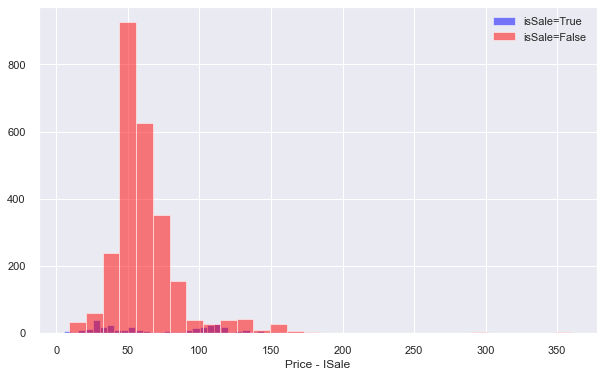

In [340]:
sns.set()
 


plt.figure(figsize=(10,6))
df[df['isSale']==True]['price'].hist(alpha=0.5,color='blue',
                                              bins=30,label='isSale=True')
df[df['isSale']==False]['price'].hist(alpha=0.5,color='red',
                                              bins=30,label='isSale=False')
plt.legend()
plt.xlabel('Price - ISale')

In [ ]:
Distribuição de preços é bem comportada e lembra uma Gaussiana (Normal)

Text(0.5, 0, 'Price - Condition')

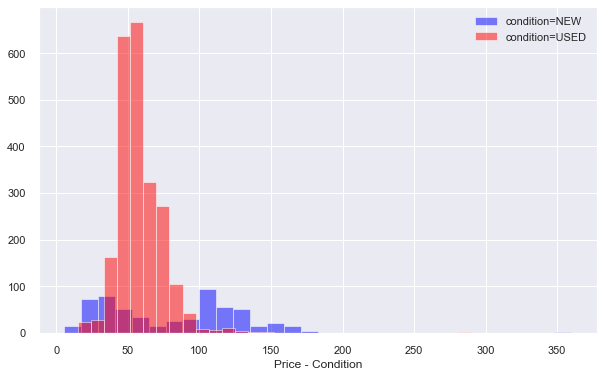

In [341]:
sns.set()
 


plt.figure(figsize=(10,6))
df[df['condition']=='NEW']['price'].hist(alpha=0.5,color='blue',
                                              bins=30,label='condition=NEW')
df[df['condition']=='USED']['price'].hist(alpha=0.5,color='red',
                                              bins=30,label='condition=USED')
plt.legend()
plt.xlabel('Price - Condition')

# Normalização

In [342]:
# normalizar dados
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['price_sc']= scaler.fit_transform(df['price'].values.reshape(-1, 1))
# statisticas do dado normalizado
pd.DataFrame(df[['price_sc','price']]).describe()

,price_sc,price
count,2.860000e+03,2860.000000
mean,2.407359e-16,62.750351
std,1.000175e+00,26.737527
min,-2.146249e+00,5.375000
25%,-5.334392e-01,48.490000
50%,-2.360523e-01,56.440000
75%,2.708147e-01,69.990000
max,1.111739e+01,359.950000


# ML- Clusterização K-Means 

In [343]:
#Encodando com one hote enconding por dummys
X = pd.get_dummies(df, columns=['categories','colors','condition'])

In [344]:
X.head()

,id,brand,isSale,price,price_sc,"categories_2 lips too,shoes,boots,womens","categories_a2 by aerosoles,shoes,clogs,mules,womens","categories_andrew geller,shoes,sandals,womens","categories_asics,womens,athletic shoes,shoes,sneakers","categories_betula by birkenstock,shoes,sandals,womens",...,colors_white,colors_whitebrooke,colors_whitefire,colors_whitegrey,colors_whitewhite,colors_wine,colors_wood,colors_yellow,condition_NEW,condition_USED
0,AVpfEf_hLJeJML431ueH,naturalizer,False,55.990,-0.252886,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,AVpfEf_hLJeJML431ueH,naturalizer,False,55.990,-0.252886,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,AVpi74XfLJeJML43qZAc,muk luks,True,41.125,-0.808943,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,AVpi74XfLJeJML43qZAc,muk luks,False,35.250,-1.028710,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,AVpjXyCc1cnluZ0-V-Gj,muk luks,False,24.750,-1.421485,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [345]:
#retirado o preço não normalizado e as features não solicitadas no desafio
X.drop(columns=['price', 'id','brand','isSale'], inplace = True)
X.columns

Index(['price_sc', 'categories_2 lips too,shoes,boots,womens',
       'categories_a2 by aerosoles,shoes,clogs,mules,womens',
       'categories_andrew geller,shoes,sandals,womens',
       'categories_asics,womens,athletic shoes,shoes,sneakers',
       'categories_betula by birkenstock,shoes,sandals,womens',
       'categories_candie's,shoes,boots,womens',
       'categories_candie's,shoes,flats,womens',
       'categories_clothing,all men's shoes,all women's shoes,shoes,men's shoes,women's shoes,women's slippers',
       'categories_clothing,all men's shoes,shoes,eastland,men's shoes,boat shoes,womens',
       ...
       'colors_white', 'colors_whitebrooke', 'colors_whitefire',
       'colors_whitegrey', 'colors_whitewhite', 'colors_wine', 'colors_wood',
       'colors_yellow', 'condition_NEW', 'condition_USED'],
      dtype='object', length=424)

# 1 - Você deve usar o algoritmo de sua preferência para agrupar os sapatos de acordo com condition, categories e colors disponíveis gerando 4 clusters.

In [346]:
from sklearn.cluster import KMeans
from numpy import unique
from numpy import where

# define o modelo
model = KMeans(n_clusters=4)
# fita o modelo
model.fit(X)
# assinala um cluster para cada linha em X 
yhat = model.predict(X)


In [347]:
#cria coluna no dataframe com os clusters
df['cluster'] = yhat

# 2 - Para cada cluster encontrado, você deve calcular o preço médio e o desvio padrão de preço.

In [348]:
df[['price','cluster']].groupby('cluster').agg(['min', 'max', 'mean','std'])

price                               
            min     max        mean        std
cluster                                       
0         5.375   78.90   38.578587  15.436978
1        15.745   99.99   57.491983  13.642822
2        14.865   95.00   56.560309  11.570654
3        78.950  359.95  119.938520  29.219430

# 3 - Como bônus, você pode apresentar os clusters num gráfico, mas essa etapa não é obrigatória.

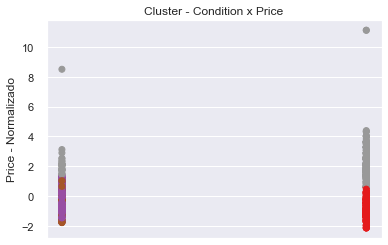

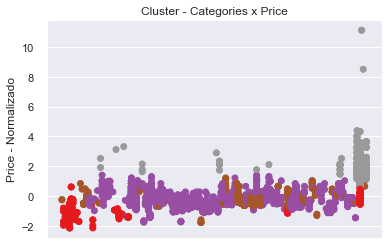

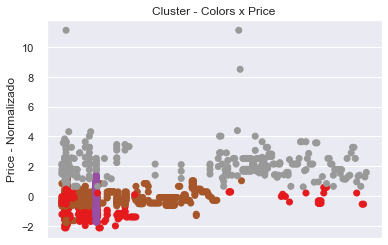

In [349]:
labels = yhat
plt.scatter(df['condition'], df['price_sc'], c=labels, cmap='Set1')
plt.xticks([])  
plt.title('Cluster - Condition x Price')
plt.ylabel('Price - Normalizado')
plt.show()

plt.scatter(df['categories'], df['price_sc'], c=labels, cmap='Set1')
plt.xticks([])
plt.title('Cluster - Categories x Price')
plt.ylabel('Price - Normalizado')
plt.show()

plt.scatter(df['colors'], df['price_sc'], c=labels, cmap='Set1')
plt.xticks([])  
plt.ylabel('Price - Normalizado')
plt.title('Cluster - Colors x Price')

 
plt.show()

# Método Elbow para quantidade ótima de clusters 

Text(0, 0.5, 'Inertia')

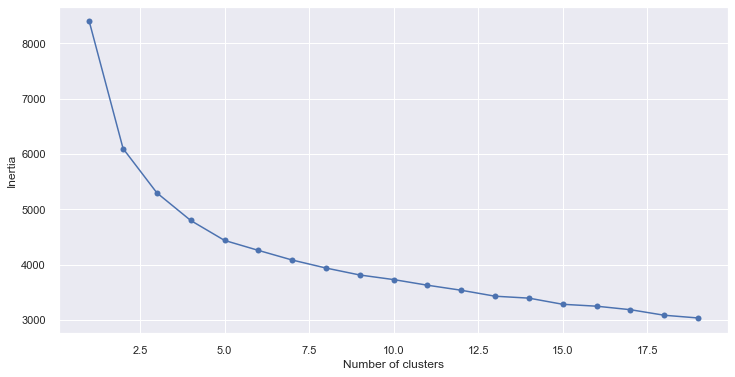

In [350]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(X) #dataframe normalizado
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

O melhor a recomendação pelo método seriam 5 Clusters! 

# PCA - reduzindo dimensionalidade para montar Quatro clusters.

In [355]:
from sklearn.decomposition import PCA # Needed for dimension reduction
pca = PCA()
principalComponents = pca.fit_transform(X)


PC = range(1, pca.n_components_+1)


# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)

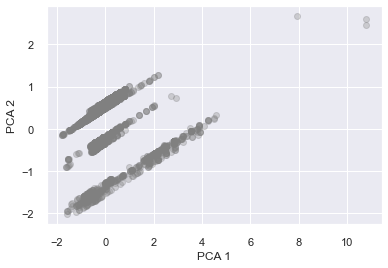

In [356]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='gray')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

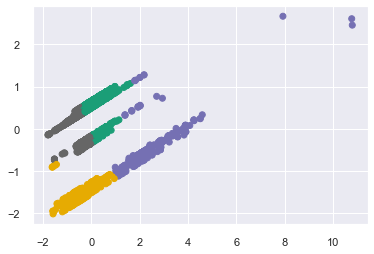

In [357]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:2])

labels = model.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels, cmap='Dark2')
plt.show()